## Import libraries & set up env for GPU use

In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
from flax import linen as nn
from typing import Sequence
import jax
from jax import vmap, jit   
import os
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import (SVI, Trace_ELBO, autoguide, init_to_median, NUTS, MCMC, TraceMeanField_ELBO)
import pandas as pd
import pickle 
from numpyro.contrib.module import random_flax_module, flax_module
# from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.util import Predictive, log_density 
from sklearn.model_selection import train_test_split

#%% Environment and/or CUDA commands
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
os.environ['XLA_FLAGS']="--xla_gpu_force_compilation_parallelism=1" # This is required until they update some things on PIBE
numpyro.enable_x64(use_x64=True)
path = os.getcwd()
os.chdir(path)

In [ ]:
from scipy.special import comb
def get_bezier_parameters(X, Y, degree=3):
    """ Least square qbezier fit using penrose pseudoinverse.

    Parameters:

    X: array of x data.
    Y: array of y data. Y[0] is the y point for X[0].
    degree: degree of the Bézier curve. 2 for quadratic, 3 for cubic.

    Based on https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
    and probably on the 1998 thesis by Tim Andrew Pastva, "Bézier Curve Fitting".
    """
    if degree < 1:
        raise ValueError('degree must be 1 or greater.')

    if len(X) != len(Y):
        raise ValueError('X and Y must be of the same length.')

    if len(X) < degree + 1:
        raise ValueError(f'There must be at least {degree + 1} points to '
                         f'determine the parameters of a degree {degree} curve. '
                         f'Got only {len(X)} points.')

    def bpoly(n, t, k):
        """ Bernstein polynomial when a = 0 and b = 1. """
        
        return t ** k * (1 - t) ** (n - k) * comb(n, k)
        #return comb(n, i) * ( t**(n-i) ) * (1 - t)**i

    def bmatrix(T):
        """ Bernstein matrix for Bézier curves. """
        return np.matrix([[bpoly(degree, t, k) for k in range(degree + 1)] for t in T])

    def least_square_fit(points, M):
        M_ = np.linalg.pinv(M)
        return M_ * points

    T = np.linspace(0, 1, len(X))
    M = bmatrix(T)
    points = np.array(list(zip(X, Y)))
    
    final = least_square_fit(points, M).tolist()
    final[0] = [X[0], Y[0]]
    final[len(final)-1] = [X[len(X)-1], Y[len(Y)-1]]
    return final

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=50):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000
        https://stackoverflow.com/questions/12643079/b%C3%A9zier-curve-fitting-with-scipy
        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

## Read Data

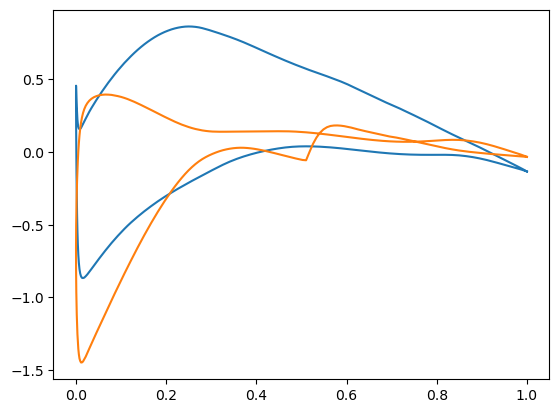

In [302]:
rng_key = random.PRNGKey(0)
num_warmup = 2000
num_samples = 1000
num_chains = 1 
init_strategy = init_to_median(num_samples=10) 
thinning = 2  

xdata = pd.read_csv('./data/XFOIL_BNN_train.csv',header=None)
ydata = pd.read_csv('./data/XFOIL_BNN_values.csv',header=None)
airfoilName = pd.read_csv('./data/XFOIL_BNN_ref.csv',header=None)
airfoilName = np.array(airfoilName.values.reshape((-1,1)))
x = xdata.values.T
y = ydata.values.T

# Do train_test_split based on airfoil, not individual cases 
def airfoil_train_test_split(X, Y, test_size, random_state, printChoice=False):
    np.random.seed(random_state) 
    airfoilsNum = np.unique(airfoilName).shape[0]
    airfoilsUnique = np.unique(airfoilName).flatten()
    case_indexing = np.arange(0, airfoilsNum) # Create index of unique cases in X 
    test_draws_indexing = np.sort(np.random.choice(case_indexing, size=int(airfoilsNum*test_size)))
    train_draws_indexing = np.sort(np.delete(case_indexing, test_draws_indexing))
    
    if printChoice:
        print(test_draws_indexing)

    for i in range(0, train_draws_indexing.shape[0]):
        ind = np.argwhere(airfoilName.flatten()==airfoilsUnique[train_draws_indexing[i]]).flatten()
        if i == 0:
            x_train = X[ind, :]
            y_train = Y[ind, :]
        else :
            x_train = np.vstack((x_train, X[ind, :]))
            y_train = np.vstack((y_train, Y[ind, :]))
    
    for j in range(0, test_draws_indexing.shape[0]):
        ind2 = np.argwhere(airfoilName.flatten()==airfoilsUnique[test_draws_indexing[j]]).flatten()
        if j == 0:
            x_test = X[ind2, :]
            y_test = Y[ind2, :]
        else :
            x_test = np.vstack((x_test, X[ind2, :]))
            y_test = np.vstack((y_test, Y[ind2, :]))
        
    return x_train, x_test, y_train, y_test 

trainPerc = 0.7 # Split percentage
xTrain, xTest, yTrain, yTest = airfoil_train_test_split(x, y, test_size = 1-trainPerc, random_state=831, printChoice=False)
afTrain, afTest, yTrain, yTest = airfoil_train_test_split(airfoilName, y, test_size = 1-trainPerc, random_state=831)
yRawMean = np.mean(yTrain,axis=0)
yTrain -= yRawMean
yTest -= yRawMean
def convert_Chebyshev(X, Y, degree):
    from numpy.polynomial import chebyshev
    # x location, Cb upper and lower
    new_data_x = np.zeros((X.shape[0], (degree+1)*2+300+1))#np.zeros((Y.flatten().shape[0], (degree+1)*2+2))
    new_data_Cp = np.zeros((Y.flatten().shape))
    counter = 0
    for i in range(X.shape[0]):
        zeroLoc = np.argwhere(np.diff(xTrain[0,:300])<= 0.0)[-1][0]
        # Obtain upper surface
        xc_u = X[i, :zeroLoc+1] # airfoil x, spans from 0 to 1 
        xc_l = X[i, zeroLoc+1:300] 
        yc_u = X[i, 300:300+zeroLoc+1] # airfoil thickness
        yc_l = X[i, 300+zeroLoc+1:300+300]
        Cp_u = Y[i, :zeroLoc+1]
        Cp_l = Y[i, zeroLoc+1:]
        AoA = X[i, -1] # angle of attack

        xc_temp_u = xc_u*2+-1 # Expand to -1 to 1 range for cheby
        xc_temp_l = xc_l*2+-1
        fit_u = chebyshev.Chebyshev.fit(xc_temp_u, Cp_u, degree)
        fit_l = chebyshev.Chebyshev.fit(xc_temp_l, Cp_l, degree)
        
        # for j in range(0, 300):
        #     if j < zeroLoc:
        #         xloc_value = -X[i, j] # correcting training data x cuz me dumb
        #     else : 
        #         xloc_value = X[i, j]
                
        values = np.hstack((fit_u.coef, fit_l.coef, xc_u, xc_l, AoA))
        new_data_x[i, :] = values
        #    new_data_Cp[counter] = Y[i, j]
        #    counter += 1 
            
        # new_data_x[] = np.hstack((coeffs, xLoc, alpha))
        # use this if u wanna evaluate
        out_u = np.polynomial.chebyshev.chebval(xc_temp_u, fit_u.coef)
        out_l = np.polynomial.chebyshev.chebval(xc_temp_l, fit_l.coef)
        plt.plot(xc_u, out_u)
        plt.plot(xc_l, out_l)
    return new_data_x

def CST_fit(x, y, degree):
    import scipy
    zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
    x_u = x[:zeroLoc+1].flatten()
    x_l = x[zeroLoc+1:].flatten()
    y_u = y[:zeroLoc+1].flatten()
    y_l = y[zeroLoc+1:].flatten()
    design_matrix_u = np.zeros((x_u.shape[0], degree+1))
    design_matrix_l = np.zeros((x_l.shape[0], degree+1))
    for i in range(0,degree+1):
        design_matrix_u[:,i] = scipy.special.comb(N=degree,k=i*np.ones(x_u.shape)) \
            * (x_u**i*(1-x_u**(degree-i)))
        design_matrix_l[:,i] = scipy.special.comb(N=degree,k=i*np.ones(x_l.shape)) \
            * (x_l**i*(1-x_l**(degree-i)))
            
    # Solve for coefficients
    coeffs_yu = scipy.linalg.lstsq(design_matrix_u, y_u)[0]
    coeffs_yl = scipy.linalg.lstsq(design_matrix_l, y_l)[0]
    return (coeffs_yu, coeffs_yl), (design_matrix_u, design_matrix_l), (x_u, x_l)

def pressure_fit(x, y, degree, plotResult=False):
    zeroLoc = np.argwhere(np.diff(x)<= 0.0)[-1][0]
    x_u = x[:zeroLoc+1].flatten()
    x_l = x[zeroLoc+1:].flatten()
    # boundInd1 = np.argwhere(x_u<0.3).flatten()
    # boundInd2 = np.argwhere(x_u>=0.3).flatten()
    # boundInd3 = np.argwhere(x_l<0.3).flatten()
    # boundInd4 = np.argwhere(x_l>=0.3).flatten()
    
    # x_u_LE = x_u[boundInd1]
    # x_u_TE = x_u[boundInd2]
    # x_l_LE = x_l[boundInd3]
    # x_l_TE = x_l[boundInd4]
    
    y_u = y[:zeroLoc+1].flatten()
    y_l = y[zeroLoc+1:].flatten()
    # y_u_LE = y_u[boundInd1]
    # y_u_TE = y_u[boundInd2]
    # y_l_LE = y_l[boundInd3]
    # y_l_TE = y_l[boundInd4]
    
    points_u = []
    points_l = []
    for i in range(len(x_u)):
        points_u.append([x_u[i],y_u[i]])
    for i in range(len(points_l)):
        points_l.append([x_l[i],y_l[i]])
    bezier_u = get_bezier_parameters(x_u, y_u, degree=degree)
    bezier_l = get_bezier_parameters(x_l, y_l, degree=degree)
    # bezier_l_LE = get_bezier_parameters(x_l_LE, y_l_LE, degree=degree)
    # bezier_l_TE = get_bezier_parameters(x_l_TE, y_l_TE, degree=degree)
    
    if plotResult:
        xu_val, yu_val = bezier_curve(bezier_u, nTimes=50)
        xl_val, yl_val = bezier_curve(bezier_l, nTimes=50)
        plt.plot(xu_val, yu_val)
        plt.plot(xl_val, yl_val)
    return (np.array(bezier_u), np.array(bezier_l))

def convert_Berstein(X, Y, deg):
    degree1 = deg[0]
    degree2 = deg[1]
    import scipy
    # Convert X to airfoil information
    new_data_x = np.zeros((X.shape[0], 2*(degree1+1)+1))#np.zeros((Y.flatten().shape[0], (degree+1)*2+2))
    new_data_Cp = np.zeros((X.shape[0], 4*(degree2+1))) 
    
        # Create design matrix 
    for i in range(X.shape[0]): # Loop through all cases 
        coeff_af, dmat_af, x_af = CST_fit(X[i,:300], X[i,300:600], degree1)
        AoA = X[i, -1]
        new_data_x[i,:] = np.hstack((coeff_af[0], coeff_af[1], AoA))
        
        # coeff_Cp, dmat_Cp, x_Cp = CST_fit(X[i,:300], Y[i,:], degree2)
        coeff_Cp = pressure_fit(X[i,:300], Y[i,:], degree=degree2, plotResult=False)
        # print(coeff_Cp[0].shape)
        new_data_Cp[i,:] = np.hstack((coeff_Cp[0][:,0]*10, coeff_Cp[0][:,1], coeff_Cp[1][:,0]*10, coeff_Cp[1][:,1]))
    return new_data_x, new_data_Cp, (dmat_af, 1)
    
# plt.plot(xt, yt, "k.",label='Original Points')
# Get the Bezier parameters based on a degree.
plt.plot(xTrain[0,:300], yTrain[0,:])
plt.plot(xTrain[0,:300], yTrain[35,:])
# plt.plot(yTrain[103,:])
# plt.plot(yTrain[158,:])
# plt.plot(yTrain[325,:])

viewInd = 231
# data = pressure_fit(xTrain[viewInd,:300:4], yTrain[viewInd,::4], degree=18, plotResult=True)
# plt.plot(xTrain[viewInd,:300], yTrain[viewInd,:],'k--',alpha=0.5)
# plt.plot(xTrain[viewInd,:300:], yTrain[viewInd,:],'ko--',alpha=0.5)
xTrain, yTrain, a = convert_Berstein(xTrain[:100,:], yTrain[:100,:], [8, 11])
xTest, yTest, b = convert_Berstein(xTest, yTest, [8, 11])


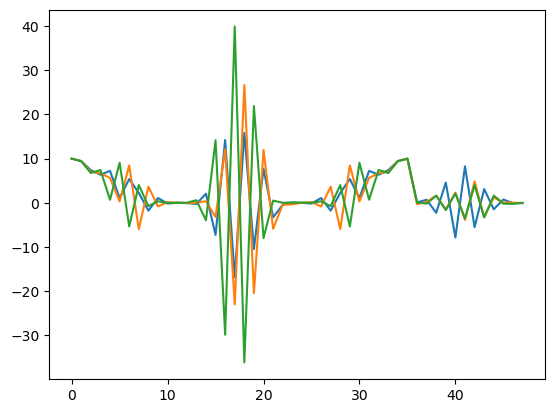

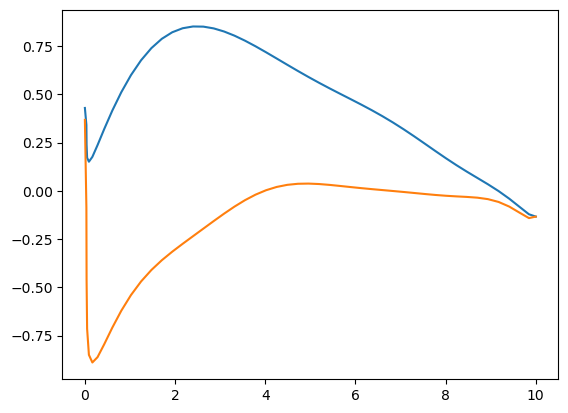

In [303]:
plt.plot(yTrain[20,:])
plt.plot(yTrain[40,:])
plt.plot(yTrain[50,:])

#
plt.figure()
xu_val, yu_val = bezier_curve(yTrain[0,:24].reshape((12,2),order='F').tolist(), nTimes=50)
xl_val, yl_val = bezier_curve(yTrain[0,24:].reshape((12,2),order='F').tolist(), nTimes=50)
plt.plot(xu_val, yu_val)
plt.plot(xl_val, yl_val)
# xl_val, yl_val = bezier_curve(bezier_l, nTimes=50)

In [304]:
# MLP setup from flax - Old 
class MLP(nn.Module):
  layers: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.layers[:-1]:
      x = nn.tanh(nn.Dense(feat)(x))
    x = nn.Dense(self.layers[-1])(x) # 
    return x
  
def airfoil_Cp_predictor(x, y=None):
    mlp = random_flax_module(
        "mlp",
        MLP([300, 300, 300]),
        prior=dist.Normal(),
        input_shape=(x.shape[1],),
    )
  
    with numpyro.plate("obs", x.shape[0]):
        mu = mlp(x).squeeze() 
        sig = 0.02 # Fake standard dev for XFOIL data
        # numpyro.deterministic("y", mu, obs=y)
        numpyro.sample("y", dist.Normal(mu, sig).to_event(1), obs=y,)

# Non-linear operation
def nonlin(x):
    return jnp.tanh(x)

# Different model structure - effectively same as the one defined in airfoil_CP_predictor
def model_bnn(X, Y=None, num_Neurons=[100, 100, 100], sigma_w=1):
  D_X, D_Y = X.shape[1], yTrain.shape[1]
  N = X.shape[0]
  # sample first layer (we put unit normal priors on all weights)
  w1 = numpyro.sample("w1", dist.Normal(jnp.zeros((D_X, num_Neurons[0])), sigma_w*jnp.ones((D_X, num_Neurons[0]))))  
  b1 = numpyro.sample("b1", dist.Normal(jnp.zeros((num_Neurons[0], 1)), sigma_w*jnp.ones((num_Neurons[0], 1))))
  z1 = nonlin(jnp.matmul(X, w1) + jnp.transpose(b1))   # N D_H  <= first layer of activations

  # sample second layer
  w2 = numpyro.sample("w2", dist.Normal(jnp.zeros((num_Neurons[0], num_Neurons[1])), sigma_w*jnp.ones((num_Neurons[0], num_Neurons[1])))) 
  b2 = numpyro.sample("b2", dist.Normal(jnp.zeros((num_Neurons[1], 1)), sigma_w*jnp.ones((num_Neurons[1], 1))))  # D_H 1
  z2 = nonlin(jnp.matmul(z1, w2) + jnp.transpose(b2))  # N D_H  <= second layer of activations
  
  w3 = numpyro.sample("w3", dist.Normal(jnp.zeros((num_Neurons[1], num_Neurons[2])), sigma_w*jnp.ones((num_Neurons[1], num_Neurons[2])))) 
  b3 = numpyro.sample("b3", dist.Normal(jnp.zeros((num_Neurons[2], 1)), sigma_w*jnp.ones((num_Neurons[2], 1))))  # D_H 1
  z3 = nonlin(jnp.matmul(z2, w3) + jnp.transpose(b3))  # N D_H  <= thrid layer of activations
  
  wf = numpyro.sample("wf", dist.Normal(jnp.zeros((num_Neurons[2], D_Y)), sigma_w*jnp.ones((num_Neurons[2], D_Y)))) 
  bf = numpyro.sample("bf", dist.Normal(jnp.zeros((D_Y, 1)), sigma_w*jnp.ones((D_Y, 1))))  # D_H 1
  zf = jnp.matmul(z3, wf) + jnp.transpose(bf)  # N D_H  <= f layer of activations
 
  with numpyro.plate("obs", N):
    # note we use to_event(1) because each observation has shape (1,)
    numpyro.sample("Y", dist.Normal(zf, 1e-8).to_event(1), obs=Y) # 1e-4
    # To do: this causes the jaggedness due to independent noise obs, need to define multivariate version to get a smoother function even with noise
    
    # add penalty promoting smoothness
    # numpyro.factor("penalty-smooth", smoothness_penalty(zf, 10))

def run_inference(XX, yy):
  start = time.time()
  kernel = NUTS(model_bnn, 
                init_strategy=init_to_median(num_samples=10))
  mcmc = MCMC(
      kernel, num_warmup = num_warmup, \
      num_samples = num_samples, \
      num_chains = num_chains, \
      thinning = thinning, \
      progress_bar=True
  )
  key = random.PRNGKey(0)
  mcmc.run(key, XX, yy)
  mcmc.print_summary()
  print("\nMCMC elapsed time:", time.time() - start)
  return mcmc.get_samples()

def smoothness_penalty(val, scale):
    # Compute the gradient of the latent function
    grad = jnp.gradient(jnp.gradient(val.reshape((-1,150),order='C'),axis=1),axis=1)
    #yTest.reshape((-1,150),order='C'
    # Compute the penalty term based on the gradient
    penalty = jnp.sum(jnp.square(grad))  # Example: L2 penalty
    
    return -scale*penalty
  
def weight_penalty(val, scale=1):
  penalty = jnp.sum(jnp.square(val))
  return -scale*penalty

## Train model

  0%|          | 0/100000 [00:00<?, ?it/s]2024-02-04 12:10:43.389670: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

100%|██████████| 100000/100000 [00:49<00:00, 2002.06it/s, init loss: 1482892723010172616704.0000, avg. loss [95001-100000]: 71225356936819808.0000]


Text(0, 0.5, 'Loss')

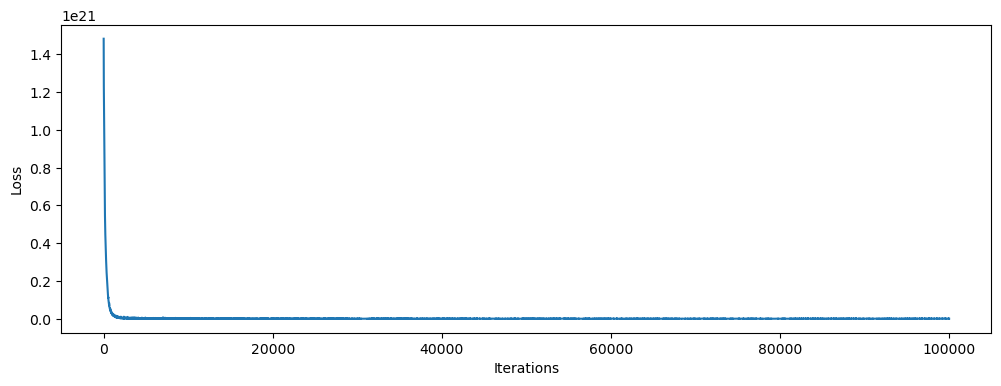

In [305]:
trainNew = True
if trainNew == True:
    # Train new SVI model
    total_iterations = 0
    svi_init_state = None
    guide = autoguide.AutoDelta(model=model_bnn)
    optimizer = numpyro.optim.Adam(step_size = 0.001)
    svi = SVI(model_bnn, guide, optimizer, loss=Trace_ELBO())
elif trainNew == False:
    # Continue the save
    print('Continuing from previous SVI state...') 
    # optimizer = numpyro.optim.Minimize(step_size = 0.001)
    svi.optimizer = numpyro.optim.Adam(step_size = 0.0001)
    svi_init_state = svi_result.state
else:
     raise ValueError('Incorrect input')

n_samples = 10000*10
total_iterations += n_samples
svi_result = svi.run(rng_key, n_samples, xTrain, yTrain-np.mean(yTrain,axis=0), [100, 100, 100], init_state=svi_init_state) # -np.mean(yTrain,axis=0)
plt.figure(figsize=(12,4))
plt.plot(svi_result.losses)
plt.xlabel('Iterations')
plt.ylabel('Loss') 


Set up Predictive from the trained model parameters

In [306]:
params = svi_result.params
# get posterior predictive (deterministics and likelihood)
posterior_predictive = Predictive(
    model=model_bnn, guide=guide, params=params, num_samples= 200
)

rng_key, rng_subkey = random.split(key=rng_key)  

## Determining Gaussianity

In [ ]:
# Samples from the posterior predictive 
numDraws = 100
params = svi_result.params
prediction_sampler = Predictive(
    model=model_bnn, guide=guide, params=params, num_samples= numDraws
)
MLP_draws = np.squeeze(prediction_sampler(rng_key, xTrain[81:82,:])['Y'])
MLP_draws_mu = np.mean(MLP_draws, axis=0)
MLP_draws_sig = np.std(MLP_draws, axis=0)

# Samples from a true normal distribution with the determined mean and sigma
trueN_draws = np.squeeze(dist.Normal(loc=MLP_draws_mu, scale = MLP_draws_sig).sample(key = rng_key, sample_shape=(numDraws,)))
# For debugging - making sure the results are expected when distribution is not normal
debugN_draws = np.squeeze(dist.Cauchy(loc=MLP_draws_mu, scale = MLP_draws_sig).sample(key = rng_key, sample_shape=(numDraws,)))

import scipy
p = []
# Perform 2-sample KS test for all 300 points 
for i in range(0, MLP_draws.shape[1]):
    p_sample = MLP_draws[:,i] 
    q_sample = trueN_draws[:,i] 
    ks_result = scipy.stats.ks_2samp(p_sample, q_sample)
    p.append(ks_result.pvalue)  

# Null hypothesis: Two samples are same drawn from same distribution (P > 0.05)
# Alternative - 2-sided: Two samples are not from the identical distribution (P <= 0.05)
plt.plot(np.array(p)>=0.05,'.')
plt.xlabel('Neuron')
plt.ylabel('Distribution')
plt.yticks([0.0, 1.0], ['Is not Gaussian', 'Is Gaussian'])
plt.show()

## Save model params

In [ ]:
architecture = 'MLP'
num_neurons = '300'
noise_value = 0.02
additional_notes = 'XFOIL prototype'
meta = [architecture, num_neurons, noise_value, n_samples, additional_notes]
data = [xTrain, xTest, afTrain, afTest, yTrain, yTest]
saveData = [svi_result, guide, data, meta]

saveData = {} 
saveData['model'] = model_bnn
saveData['params'] = svi_result.params
saveData['guide'] = guide
saveData['data'] = data
saveData['meta'] = meta 
# with open('/home/hlee981/Documents/Lift Distribution/Onera M6/Prior Generator Model/quickload.pkl', 'wb') as file:
#         pickle.dump(saveData, file)

## Validation on NACA 4-digit series

In [ ]:
setNew = True
if setNew == True:
    post_pred_train = posterior_predictive(rng_subkey, xTrain)
    mu = np.mean(np.squeeze(post_pred_train['Y']), axis=0)+np.mean(yTrain,axis=0)
    std = np.std(np.squeeze(post_pred_train['Y']), axis=0)

    post_pred_test = posterior_predictive(rng_subkey, xTest)
    mu_t = np.mean(np.squeeze(post_pred_test['Y']), axis=0)+np.mean(yTrain,axis=0)
    std_t = np.std(np.squeeze(post_pred_test['Y']), axis=0)

def verifyCpResults(indRange, x, cp, mu, std, names, ax, subplotInd):
    ax[subplotInd].plot(x, mu[indRange,:] ,'r', label =  'Mean prediction, $\mu$')
    ax[subplotInd].fill_between(x, mu[indRange,:]-std[indRange,:], mu[indRange,:]+std[indRange,:], color='r', alpha = 0.4, label='$\mu \pm \sigma$, 68% CI')
    ax[subplotInd].fill_between(x, mu[indRange,:]-2*std[indRange,:], mu[indRange,:]+2*std[indRange,:], color='r', alpha = 0.2, label = '$\mu \pm 2\sigma$, 95% CI')
    ax[subplotInd].plot(x, cp[indRange],'k--', label= 'XFOIL Data')
    ax[subplotInd].invert_yaxis() 
    ax[subplotInd].set_xlabel('x/c')
    ax[subplotInd].set_ylabel('$C_p$')
    titleStr = str(names[indRange][0]) + r", $\alpha$ = " + str(xTrain[indRange,-1]) + ' deg'
    ax[subplotInd].title.set_text(titleStr)

# Verify fits on the trainingData
fig, ax = plt.subplots(1,6, figsize=(32,4))
verifyCpResults(40, jnp.abs(xTrain[40,:300]), yTrain, mu, std, afTrain, ax, 0)
verifyCpResults(82, jnp.abs(xTrain[82,:300]), yTrain, mu, std, afTrain, ax, 1)
verifyCpResults(100, jnp.abs(xTrain[100,:300]), yTrain, mu, std, afTrain, ax, 2)
verifyCpResults(200, jnp.abs(xTrain[200,:300]), yTrain, mu, std, afTrain, ax, 3)
verifyCpResults(300, jnp.abs(xTrain[300,:300]), yTrain, mu, std, afTrain, ax, 4)
verifyCpResults(381, jnp.abs(xTrain[381,:300]), yTrain, mu, std, afTrain, ax, 5)
ax[0].legend()
fig.suptitle('Checking predictions on training data')

# Verify fits on the testing data
plt.figure()
fig, ax = plt.subplots(1,6, figsize=(32,4))
verifyCpResults(10, jnp.abs(xTest[10,:300]), yTest, mu_t, std_t, afTest, ax, 0)
verifyCpResults(15, jnp.abs(xTest[15,:300]), yTest, mu_t, std_t, afTest, ax, 1)
verifyCpResults(20, jnp.abs(xTest[20,:300]), yTest, mu_t, std_t, afTest, ax, 2)
verifyCpResults(25, jnp.abs(xTest[25,:300]), yTest, mu_t, std_t, afTest, ax, 3)
verifyCpResults(35, jnp.abs(xTest[35,:300]), yTest, mu_t, std_t, afTest, ax, 4)
verifyCpResults(40, jnp.abs(xTest[40,:300]), yTest, mu_t, std_t, afTest, ax, 5)
ax[0].legend()
fig.suptitle('Checking predictions on test data')

## Validation on other types of airfoils

Need to do this, only the XFOIL the data is plotted as of now

Case 1: Clark Y

In [ ]:
yMean = np.mean(yTrain, axis=0)

# Read Clark Y Coordinates
fileLoc = './data/validation_ClarkY/'
clark_y = np.loadtxt(fileLoc+"clark_y.txt", delimiter=' ')

coeffs, dmatrix, new_x = CST_fit(clark_y[:,0], clark_y[:,1], 8)
plt.figure()
plt.plot(new_x[0], dmatrix[0] @ coeffs[0], 'r-', label = 'Fitted profile')
plt.plot(new_x[1], dmatrix[1] @ coeffs[1], 'r-')
plt.plot(clark_y[::4,0], clark_y[::4,1], 'k.', label = 'Clark Y profile')
plt.xlabel('x/c')
plt.ylabel('z/c')
plt.axis('scaled')
plt.ylim([-0.15,0.15])
plt.legend()

# Case a) a = 0 deg
f_case1, ax_case1 = plt.subplots(2,3,figsize=(14,8))
case1a = np.hstack((coeffs[0], coeffs[1], 0)).reshape((1,-1))
# case1a_results = posterior_predictive(rng_subkey, case1a)
# ax_case1[0,0].plot(np.abs(np.linspace(-1,1,300)), np.mean(np.squeeze(case1a_results['Y'][:,0,:]),axis=0)+yMean)

    # Validation data 
case1a_val = np.loadtxt(fileLoc+"clarkY_0.txt", delimiter=' ')
ax_case1[0,0].plot(case1a_val[:,0], case1a_val[:,2],'k--', label='XFOIL')
ax_case1[0,0].set_xlabel('x/c [1]')
ax_case1[0,0].set_ylabel('$C_p$ [1]')
ax_case1[0,0].title.set_text('0 deg')
ax_case1[0,0].set_ylim([-1.6, 1.1])
ax_case1[0,0].invert_yaxis()

# Case b) a = 1 deg
    # Validation data 
case1b_val = np.loadtxt(fileLoc+"clarkY_1.txt", delimiter=' ')
ax_case1[0,1].plot(case1b_val[:,0], case1b_val[:,2],'k--', label='XFOIL')
ax_case1[0,1].set_xlabel('x/c [1]')
ax_case1[0,1].set_ylabel('$C_p$ [1]')
ax_case1[0,1].title.set_text('1 deg')
ax_case1[0,1].set_ylim([-1.6, 1.1])
ax_case1[0,1].invert_yaxis()

# Case c) a = 2 deg
    # Validation data 
case1c_val = np.loadtxt(fileLoc+"clarkY_2.txt", delimiter=' ')
ax_case1[0,2].plot(case1c_val[:,0], case1c_val[:,2],'k--', label='XFOIL')
ax_case1[0,2].set_xlabel('x/c [1]')
ax_case1[0,2].set_ylabel('$C_p$ [1]')
ax_case1[0,2].title.set_text('2 deg')
ax_case1[0,2].set_ylim([-1.6, 1.1])
ax_case1[0,2].invert_yaxis()

# Case d) a = 3 deg
    # Validation data 
case1d_val = np.loadtxt(fileLoc+"clarkY_3.txt", delimiter=' ')
ax_case1[1,0].plot(case1d_val[:,0], case1d_val[:,2],'k--', label='XFOIL')
ax_case1[1,0].set_xlabel('x/c [1]')
ax_case1[1,0].set_ylabel('$C_p$ [1]')
ax_case1[1,0].title.set_text('3 deg')
ax_case1[1,0].set_ylim([-1.6, 1.1])
ax_case1[1,0].invert_yaxis()

# Case e) a = 4 deg
    # Validation data 
case1e_val = np.loadtxt(fileLoc+"clarkY_4.txt", delimiter=' ')
ax_case1[1,1].plot(case1e_val[:,0], case1e_val[:,2],'k--', label='XFOIL')
ax_case1[1,1].set_xlabel('x/c [1]')
ax_case1[1,1].set_ylabel('$C_p$ [1]')
ax_case1[1,1].title.set_text('4 deg')
ax_case1[1,1].set_ylim([-1.6, 1.1])
ax_case1[1,1].invert_yaxis()

# Case f) a = 5 deg
    # Validation data 
case1f_val = np.loadtxt(fileLoc+"clarkY_5.txt", delimiter=' ')
ax_case1[1,2].plot(case1f_val[:,0], case1f_val[:,2],'k--', label='XFOIL')
ax_case1[1,2].set_xlabel('x/c [1]')
ax_case1[1,2].set_ylabel('$C_p$ [1]')
ax_case1[1,2].title.set_text('5 deg')
ax_case1[1,2].set_ylim([-1.6, 1.1])
ax_case1[1,2].invert_yaxis()

Case 2: Onera D

In [ ]:
# Read Clark Y Coordinates
fileLoc = './data/validation_OneraD/'
onera_D = np.loadtxt(fileLoc+"oneraD.txt", delimiter=' ')

coeffs, dmatrix, new_x = CST_fit(onera_D[:,0], onera_D[:,1], 8)
plt.figure()
plt.plot(new_x[0], dmatrix[0] @ coeffs[0], 'r-', label = 'Fitted profile')
plt.plot(new_x[1], dmatrix[1] @ coeffs[1], 'r-')
plt.plot(onera_D[::4,0], onera_D[::4,1], 'k.', label = 'Onera D profile')
plt.xlabel('x/c')
plt.ylabel('z/c')
plt.axis('scaled')
plt.ylim([-0.15,0.15])
plt.legend()

# Case a) a = 0 deg
f_case1, ax_case2 = plt.subplots(2,3,figsize=(14,8))
case2a = np.hstack((coeffs[0], coeffs[1], 0)).reshape((1,-1))
# case2a_results = posterior_predictive(rng_subkey, case2a)
# ax_case2[0,0].plot(np.abs(np.linspace(-1,1,300)), np.mean(np.squeeze(case2a_results['Y'][:,0,:]),axis=0)+yMean)

    # Validation data 
case2a_val = np.loadtxt(fileLoc+"oneraD_0.txt", delimiter=' ')
ax_case2[0,0].plot(case2a_val[:,0], case2a_val[:,2],'k--', label='XFOIL')
ax_case2[0,0].set_xlabel('x/c [1]')
ax_case2[0,0].set_ylabel('$C_p$ [1]')
ax_case2[0,0].title.set_text('0 deg')
ax_case2[0,0].set_ylim([-2.2, 1.1])
ax_case2[0,0].invert_yaxis()

# Case b) a = 1 deg
    # Validation data 
case2b_val = np.loadtxt(fileLoc+"oneraD_1.txt", delimiter=' ')
ax_case2[0,1].plot(case2b_val[:,0], case2b_val[:,2],'k--', label='XFOIL')
ax_case2[0,1].set_xlabel('x/c [1]')
ax_case2[0,1].set_ylabel('$C_p$ [1]')
ax_case2[0,1].title.set_text('1 deg')
ax_case2[0,1].set_ylim([-2.2, 1.1])
ax_case2[0,1].invert_yaxis()

# Case c) a = 2 deg
    # Validation data 
case2c_val = np.loadtxt(fileLoc+"oneraD_2.txt", delimiter=' ')
ax_case2[0,2].plot(case2c_val[:,0], case2c_val[:,2],'k--', label='XFOIL')
ax_case2[0,2].set_xlabel('x/c [1]')
ax_case2[0,2].set_ylabel('$C_p$ [1]')
ax_case2[0,2].title.set_text('2 deg')
ax_case2[0,2].set_ylim([-2.2, 1.1])
ax_case2[0,2].invert_yaxis()

# Case d) a = 3 deg
    # Validation data 
case2d_val = np.loadtxt(fileLoc+"oneraD_3.txt", delimiter=' ')
ax_case2[1,0].plot(case2d_val[:,0], case2d_val[:,2],'k--', label='XFOIL')
ax_case2[1,0].set_xlabel('x/c [1]')
ax_case2[1,0].set_ylabel('$C_p$ [1]')
ax_case2[1,0].title.set_text('3 deg')
ax_case2[1,0].set_ylim([-2.2, 1.1])
ax_case2[1,0].invert_yaxis()

# Case e) a = 4 deg
    # Validation data 
case2e_val = np.loadtxt(fileLoc+"oneraD_4.txt", delimiter=' ')
ax_case2[1,1].plot(case2e_val[:,0], case2e_val[:,2],'k--', label='XFOIL')
ax_case2[1,1].set_xlabel('x/c [1]')
ax_case2[1,1].set_ylabel('$C_p$ [1]')
ax_case2[1,1].title.set_text('4 deg')
ax_case2[1,1].set_ylim([-2.2, 1.1])
ax_case2[1,1].invert_yaxis()

# Case f) a = 5 deg
    # Validation data 
case2f_val = np.loadtxt(fileLoc+"oneraD_5.txt", delimiter=' ')
ax_case2[1,2].plot(case2f_val[:,0], case2f_val[:,2],'k--', label='XFOIL')
ax_case2[1,2].set_xlabel('x/c [1]')
ax_case2[1,2].set_ylabel('$C_p$ [1]')
ax_case2[1,2].title.set_text('5 deg')
ax_case2[1,2].set_ylim([-2.2, 1.1])
ax_case2[1,2].invert_yaxis()

In [245]:
post_pred_train = posterior_predictive(rng_subkey, xTrain)
mu = np.mean(np.squeeze(post_pred_train['Y']), axis=0)+np.mean(yTrain,axis=0)
std = np.std(np.squeeze(post_pred_train['Y']), axis=0)

post_pred_test = posterior_predictive(rng_subkey, xTest)
mu_t = np.mean(np.squeeze(post_pred_test['Y']), axis=0)+np.mean(yTrain,axis=0)
std_t = np.std(np.squeeze(post_pred_test['Y']), axis=0)

2024-02-03 17:43:53.142125: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-03 17:43:53.611343: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-03 17:43:53.870380: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-03 17:43:53.977579: E external/xla/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscom

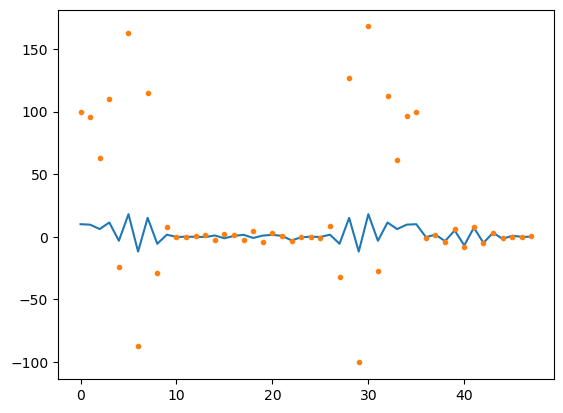

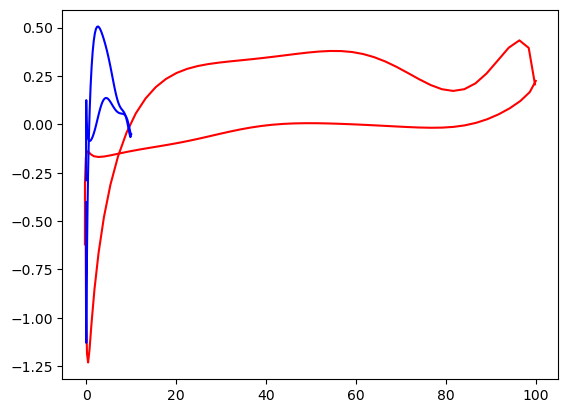

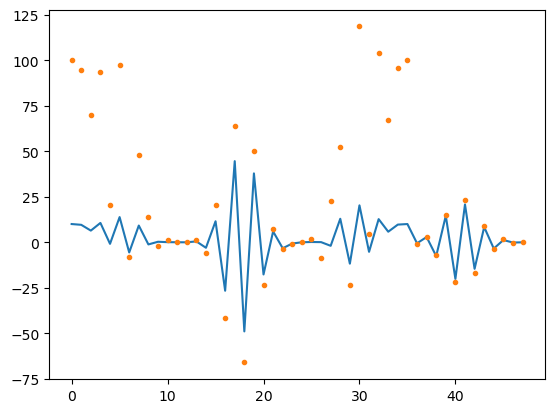

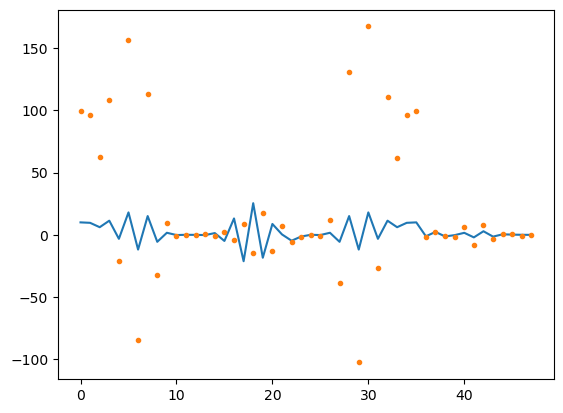

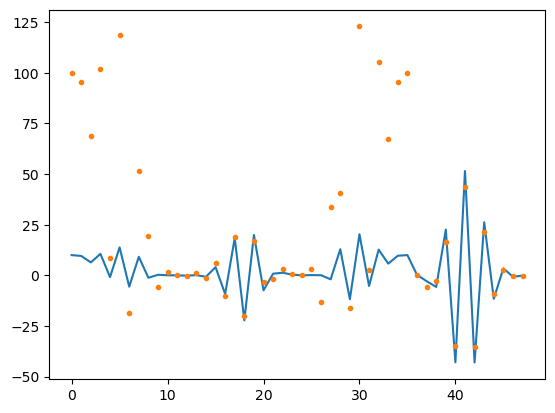

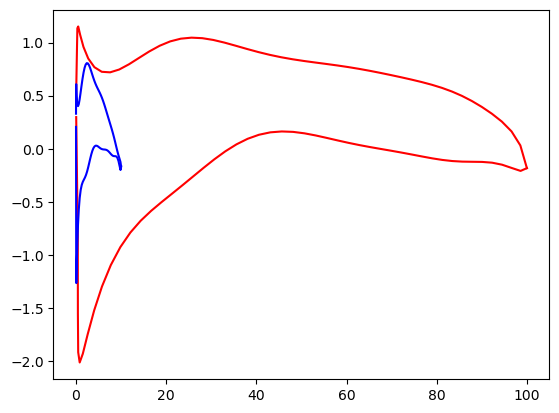

In [307]:
plt.figure()
plt.plot(yTest[3,:])
plt.plot(mu_t[3,:],'.')
plt.figure()
xu_val, yu_val = bezier_curve(mu_t[3,:24].reshape((12,2),order='F').tolist(), nTimes=50)
xl_val, yl_val = bezier_curve(mu_t[3,24:].reshape((12,2),order='F').tolist(), nTimes=50)
plt.plot(xu_val, yu_val,'r')
plt.plot(xl_val, yl_val,'r')
xut_val, yut_val = bezier_curve(yTest[3,:24].reshape((12,2),order='F').tolist(), nTimes=50)
xlt_val, ylt_val = bezier_curve(yTest[3,24:].reshape((12,2),order='F').tolist(), nTimes=50)
plt.plot(xut_val, yut_val,'b')
plt.plot(xlt_val, ylt_val,'b')

plt.figure()
plt.plot(yTest[15,:])
plt.plot(mu_t[15,:],'.')


plt.figure()
plt.plot(yTest[5,:])
plt.plot(mu_t[5,:],'.')

plt.figure()
plt.plot(yTest[11,:])
plt.plot(mu_t[11,:],'.')
plt.figure()
xu_val, yu_val = bezier_curve(mu_t[11,:24].reshape((12,2),order='F').tolist(), nTimes=50)
xl_val, yl_val = bezier_curve(mu_t[11,24:].reshape((12,2),order='F').tolist(), nTimes=50)
plt.plot(xu_val, yu_val,'r')
plt.plot(xl_val, yl_val,'r')
xut_val, yut_val = bezier_curve(yTest[11,:24].reshape((12,2),order='F').tolist(), nTimes=50)
xlt_val, ylt_val = bezier_curve(yTest[11,24:].reshape((12,2),order='F').tolist(), nTimes=50)
plt.plot(xut_val, yut_val,'b')
plt.plot(xlt_val, ylt_val,'b')